<a href="https://colab.research.google.com/github/RazvanPaducel/Machine-Learning/blob/main/NewsClassificationBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For the dataset
from sklearn.datasets import fetch_20newsgroups
# For feature extraction (text to numbers)
# from sklearn.feature_extraction.text import TfidfVectorizer
# The classifier model
# from sklearn.naive_bayes import MultinomialNB
# A tool to chain steps together
# from sklearn.pipeline import make_pipeline

#BERT
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# For evaluating the models performance
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
print(f"{len(train_data.data)} documents in the training set.")
print(f"{len(test_data.data)} documents in the testing set.")
print(f"{len(train_data.target_names)} categories.")

11314 documents in the training set.
7532 documents in the testing set.
20 categories.


In [3]:
# TF-IDF
# Create a pipeline that first creates TF-IDF features and then trains a Naive Bayes classifier.
# model = make_pipeline(
#    TfidfVectorizer(),
#    MultinomialNB()
# )


#BERT
# custom Dataset class for PyTorch/BERT
class NewsGroupsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Load Tokenizer (bert-base-uncased is standard)
print("Loading BERT Tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 3. Tokenize the data
# We truncate to 512 tokens because BERT cannot handle longer sequences
print("Tokenizing training data...")
train_encodings = tokenizer(train_data.data, truncation=True, padding=True, max_length=512)
print("Tokenizing testing data...")
test_encodings = tokenizer(test_data.data, truncation=True, padding=True, max_length=512)

# 4. Convert to PyTorch Datasets
train_dataset = NewsGroupsDataset(train_encodings, train_data.target)
test_dataset = NewsGroupsDataset(test_encodings, test_data.target)

# 5. Initialize the Model
# num_labels=20 because we have 20 categories
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=20)

# Helper function to compute metrics during training
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}
# ---------------------

Loading BERT Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing training data...
Tokenizing testing data...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [5]:
# TF-IDF TRAINING
# Train the model on the training data
# print("Training the model...")
# model.fit(train_data.data, train_data.target)
# print("Training complete")
# -------------------------------------------

# BERT TRAINING
print("Training the BERT model (Ensure you are using a GPU)...")

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs (1 is usually enough for demo, 3 for best results)
    per_device_train_batch_size=8,   # batch size per devi3ce during training (lower if memory error)
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    eval_strategy="epoch"      # Evaluate at the end of epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
print("BERT Training complete")
# -------------------------

Training the BERT model (Ensure you are using a GPU)...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.372900,0.591693,0.833378


BERT Training complete


Running predictions on test set...


Evaluating model performance:
Accuracy: 0.833

Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.67      0.68      0.67       319
           comp.graphics       0.78      0.78      0.78       389
 comp.os.ms-windows.misc       0.83      0.82      0.82       394
comp.sys.ibm.pc.hardware       0.66      0.78      0.71       392
   comp.sys.mac.hardware       0.86      0.75      0.80       385
          comp.windows.x       0.90      0.85      0.88       395
            misc.forsale       0.84      0.94      0.89       390
               rec.autos       0.93      0.90      0.91       396
         rec.motorcycles       0.93      0.88      0.91       398
      rec.sport.baseball       0.97      0.95      0.96       397
        rec.sport.hockey       0.97      0.98      0.98       399
               sci.crypt       0.93      0.89      0.91       396
         sci.electronics       0.80      0.80      0.80       393
     

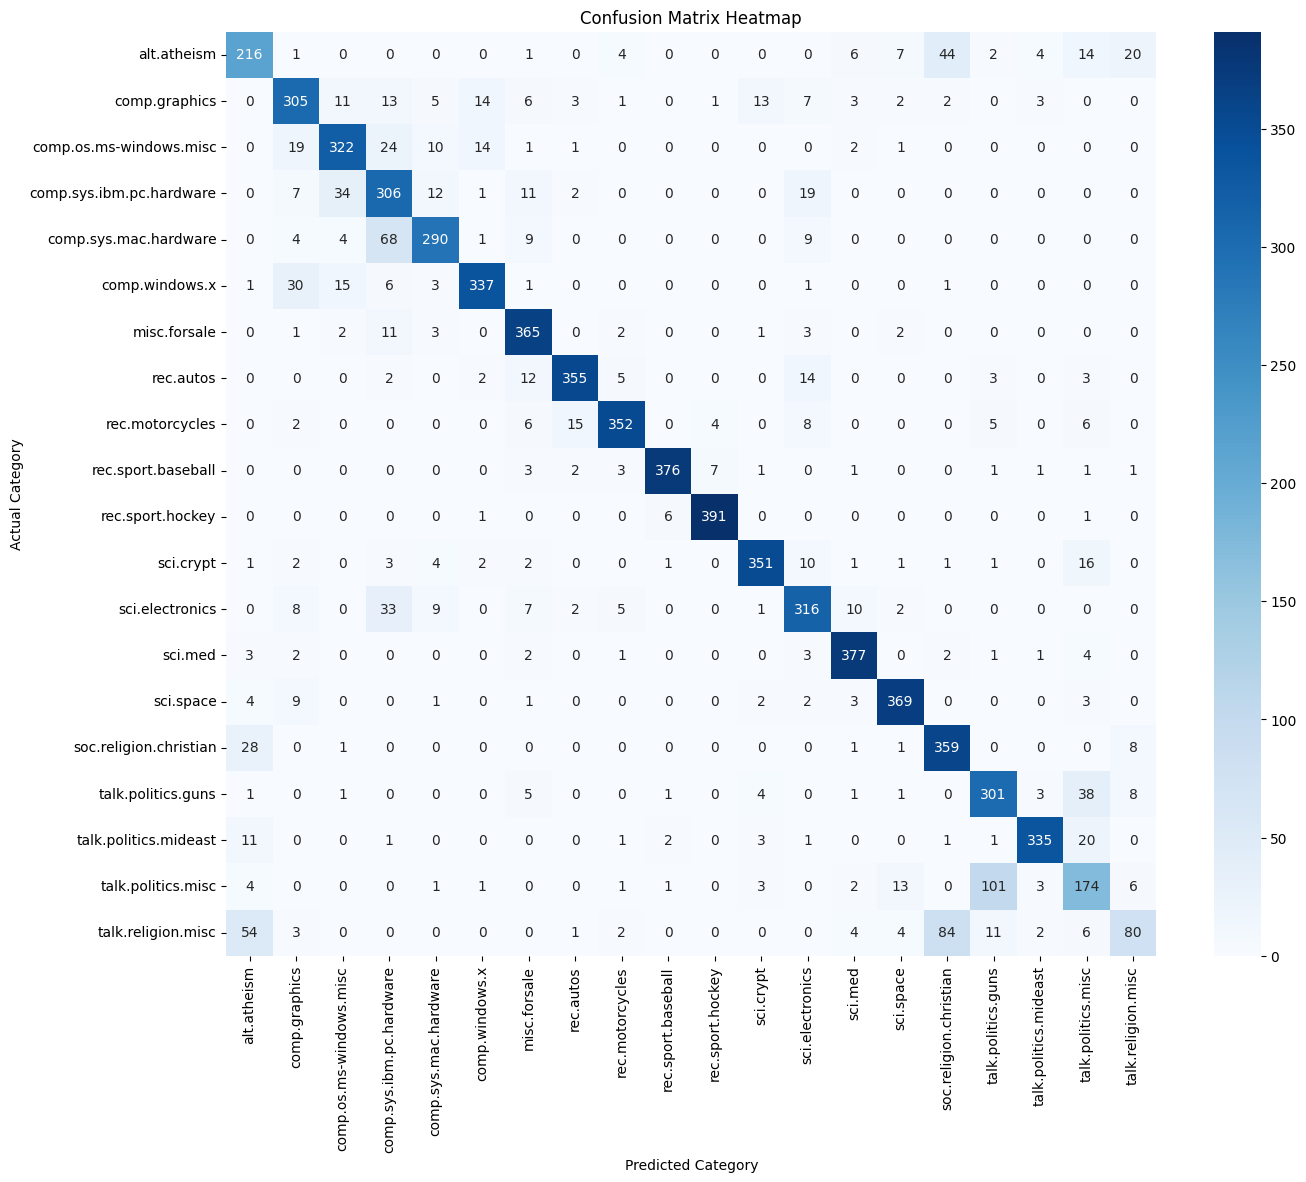

In [6]:
# Make predictions on the test set
# predicted_categories = model.predict(test_data.data)

# BERT EVALUATION
print("Running predictions on test set...")
predictions_output = trainer.predict(test_dataset)
# Convert logits to class IDs (argmax)
predicted_categories = np.argmax(predictions_output.predictions, axis=1)

# Performance metrics
print("Evaluating model performance:")
# Accuracy score = percentage of correct predictions
accuracy = metrics.accuracy_score(test_data.target, predicted_categories)
print(f"Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(metrics.classification_report(test_data.target,
                                      predicted_categories,
                                      target_names=test_data.target_names))

# Confusion matrix heatmap
conf_matrix = metrics.confusion_matrix(test_data.target, predicted_categories)

plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=test_data.target_names,
            yticklabels=test_data.target_names)

plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [7]:
# Write a sentence to test the model
new_doc = ["There was another mass shooting in America"]

# OLD PREDICTION
# predicted = model.predict(new_doc)
# print(f"Sentence: '{new_doc[0]}'")
# print(f"Predicted Category: {train_data.target_names[predicted[0]]}")

# BERT PREDICTION
# We need to tokenize the new sentence first
inputs = tokenizer(new_doc, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move inputs to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

print(f"Sentence: '{new_doc[0]}'")
print(f"Predicted Category: {train_data.target_names[predicted_class_id]}")

Sentence: 'There was another mass shooting in America'
Predicted Category: talk.politics.guns


In [8]:
import ipywidgets as widgets
widgets.Widget.close_all()